<center>
  <font size="+3">BobbleBot Controller Analysis Report<br><br></font>
  <font size="+2">Turning Control<br><br></font>
  <i>Mike Moore<br>
  <i>11/11/18<br>
  <img src="imgs/BobbleCAD.png" alt="BobbleBot CAD" style="height: 350px; width: 250px;"/>
</center>

# Introduction
This document outlines an analysis of BobbleBot controller performance as different gains are selected. At first, the BobbleBot simulator is used to capture the data and characterize the controller performance. BLAH BLAH TODO

## Loading BobbleBot Simulation Data


The BobbleBot simulator runs in Gazebo. Using the gazebo-ros packages, one can log data as the simulator runs and store it in a ros bag format. The simulation data can then be analyzed with Python using [Pandas](https://pandas.pydata.org/). This article discusses how to [load ROS bag files into Pandas](https://nimbus.unl.edu/2014/11/using-rosbag_pandas-to-analyze-rosbag-files/).

In [51]:
# Load anaylsis environment file. This file defines data directories
# and imports all needed Python packages for this notebook.
exec(open("env.py").read())
df.keys()

['response_hw_test', 'turning_test']

### Load Plot Config

In [22]:
# Set paths to relevant data directories and config files
tilt_tests_plot_config = os.path.abspath(os.path.join(os.getcwd(),'plots.yaml'))
# Load configs and data
pc = parse_config_file(tilt_tests_plot_config)

Loading configs from file : /home/mike/Work/SOE/BobbleBot/src/analysis_tools/notebooks/TurningControlAnalysis/plots.yaml


## Pre-Processing
This section applies any and all pre-processing steps needed on the data set. Examples include trimming the data, removing bias, filtering, and applying transforms.

In [52]:
max_time = 20.0
runs = ['turning_test', 'response_hw_test']
for run in runs:
    df[run] = df[run][df[run].index < max_time]

### Print sim data in tabular form
All the sim data was loaded when the analysis env file was sourced. We can get the data for a run in tabular form like so.

In [43]:
n_rows = 5
df['turning_test'].head(n_rows)

,bobble_bobble_balance_controller_bb_controller_status__ControlMode,bobble_bobble_balance_controller_bb_controller_status__DesiredTilt,bobble_bobble_balance_controller_bb_controller_status__DesiredTurnRate,bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity,bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity,bobble_bobble_balance_controller_bb_controller_status__Heading,bobble_bobble_balance_controller_bb_controller_status__HeadingEffort,bobble_bobble_balance_controller_bb_controller_status__LeftMotorEffortCmd,bobble_bobble_balance_controller_bb_controller_status__LeftMotorPosition,bobble_bobble_balance_controller_bb_controller_status__LeftMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__MeasuredTiltDot,bobble_bobble_balance_controller_bb_controller_status__MeasuredTurnRate,bobble_bobble_balance_controller_bb_controller_status__RightMotorEffortCmd,bobble_bobble_balance_controller_bb_controller_status__RightMotorPosition,bobble_bobble_balance_controller_bb_controller_status__RightMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__Tilt,bobble_bobble_balance_controller_bb_controller_status__TiltEffort,bobble_bobble_balance_controller_bb_controller_status__TiltRate,bobble_bobble_balance_controller_bb_controller_status__TurnRate,time
time,,,,,,,,,,,,,,,,,,,,
0.000,2.0,0.135135,0.0,0.0,0.003062,-174.452240,0.008503,0.008052,-16.630224,2.887904,1.387757,0.442819,-0.008953,-15.812089,4.082245,0.215049,-0.000451,1.411184,0.489383,0.000
0.005,2.0,0.136147,0.0,0.0,0.002922,-177.223785,-0.002128,-0.000262,-16.613806,3.548698,-0.680036,-0.192848,0.003994,-15.794649,3.092082,0.222569,0.001866,-0.366353,-0.124625,0.005
0.010,2.0,0.133708,0.0,0.0,0.003208,-178.610596,0.006403,0.006136,-16.595449,3.754477,1.602696,0.419900,-0.006670,-15.777328,3.712207,0.210016,-0.000267,1.307338,0.365448,0.010
0.015,2.0,0.133707,0.0,0.0,0.003171,-179.303497,-0.002408,-0.002751,-16.575130,4.270754,1.274412,-0.199522,0.002064,-15.760960,2.982960,0.209750,-0.000343,1.279351,-0.143025,0.015
0.020,2.0,0.134297,0.0,0.0,0.003078,-179.646088,-0.024353,-0.024540,-16.554840,3.917758,1.006366,-1.538551,0.024167,-15.745699,3.098735,0.202619,-0.000187,1.047314,-1.398998,0.020


### Search for a column
Here's how to search for a column(s) in a data frame.


In [9]:
search_string = 'Vel'
found_data = df['turning_test'].filter(regex=search_string)
found_data.head()

,bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity,bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity,bobble_bobble_balance_controller_bb_controller_status__LeftMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__RightMotorVelocity
time,,,,
0.000,0.0,-0.000645,-0.760880,-1.418821
0.005,0.0,-0.002440,-2.440762,-3.876041
0.010,0.0,-0.003226,-6.196395,-1.513995
0.015,0.0,-0.004785,-3.835513,-7.761353
0.020,0.0,-0.003067,-0.875882,-5.458537


BobbleBot does not track its x,y world position internally because it is not needed for the controller. For this analysis, we want to look at some commanded trajectories in world coordinates. To do this, we use a kinematic model for a differential drive robot in order to compute translational and rotational state.

### Differential Drive Model

<center>
    <br>
  <img src="imgs/diff-model.png" alt="Differential Drive Model" style="height: 400px; width: 375px;"/>
</center>

The Python code below uses the differential drive model to compute x, y position and velocity in world co-ordinates.

In [53]:
import math
wheel_radius = 0.05
wheel_base_len = 0.2286 # 9in in m

def compute_auxiliary_terms(df):
    #left_motor_vel = df['bobble_bobble_balance_controller_bb_controller_status__LeftMotorVelocity']
    #right_motor_vel = df['bobble_bobble_balance_controller_bb_controller_status__RightMotorVelocity']
    #turn_rate = (wheel_radius/wheel_base_len)*(right_motor_vel - left_motor_vel)
    #heading = scipy.integrate.cumtrapz(y=turn_rate.values, x=turn_rate.index)
    #heading = np.append(heading, heading[-1])
    turn_rate = df['bobble_bobble_balance_controller_bb_controller_status__TurnRate']
    heading = scipy.integrate.cumtrapz(y=turn_rate.values, x=turn_rate.index)
    heading = np.append(heading, heading[-1])
    fwd_vel = df['bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity']
    
    x_vel = fwd_vel * np.cos(heading*np.pi/180.0)
    y_vel = fwd_vel * np.sin(heading*np.pi/180.0)
    
    x_pos = scipy.integrate.cumtrapz(y=x_vel.values, x=x_vel.index)
    x_pos = np.append(x_pos, x_pos[-1])
    y_pos = scipy.integrate.cumtrapz(y=y_vel.values, x=y_vel.index)
    y_pos = np.append(y_pos, y_pos[-1])
    
    desired_fwd_vel = df['bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity']
    desired_turn_rate = df['bobble_bobble_balance_controller_bb_controller_status__DesiredTurnRate']
    desired_heading = scipy.integrate.cumtrapz(y=desired_turn_rate.values, x=desired_turn_rate.index)
    desired_heading = np.append(desired_heading, desired_heading[-1])
    desired_x_vel = desired_fwd_vel * np.cos(desired_heading*np.pi/180.0)
    desired_y_vel = desired_fwd_vel * np.sin(desired_heading*np.pi/180.0)
    desired_x_pos = scipy.integrate.cumtrapz(y=desired_x_vel.values, x=desired_x_vel.index)
    desired_x_pos = np.append(desired_x_pos, desired_x_pos[-1])
    desired_y_pos = scipy.integrate.cumtrapz(y=desired_y_vel.values, x=desired_y_vel.index)
    desired_y_pos = np.append(desired_y_pos, desired_y_pos[-1])

    df['bobble_bobble_balance_controller_bb_controller_status__Heading'] = heading
    df['DerivedHeading'] = heading
    df['DesiredHeading'] = desired_heading
    df['DesiredXPos'] = desired_x_pos
    df['DesiredYPos'] = desired_y_pos
    df['DerivedXPos'] = x_pos
    df['DerivedYPos'] = y_pos

for run in runs:
   compute_auxiliary_terms(df[run])

# Plot Trajectories
First define common plot configuration objects

In [13]:
kp_legend = {
    'Kp 0.1': {
        'color': 'orange',
        'linestyle': '-'
    },
    'Kp 0.15': {
        'color': 'blue',
        'linestyle': '-'
    },
    'Kp 0.2': {
        'color': 'red',
        'linestyle': '-'
    },
}
ki_legend = {
    'Ki 0.0005': {
        'color': 'orange',
        'linestyle': '-'
    },
    'Ki 0.001': {
        'color': 'blue',
        'linestyle': '-'
    },
    'Ki 0.005': {
        'color': 'red',
        'linestyle': '-'
    },
}

## Velocity Plot

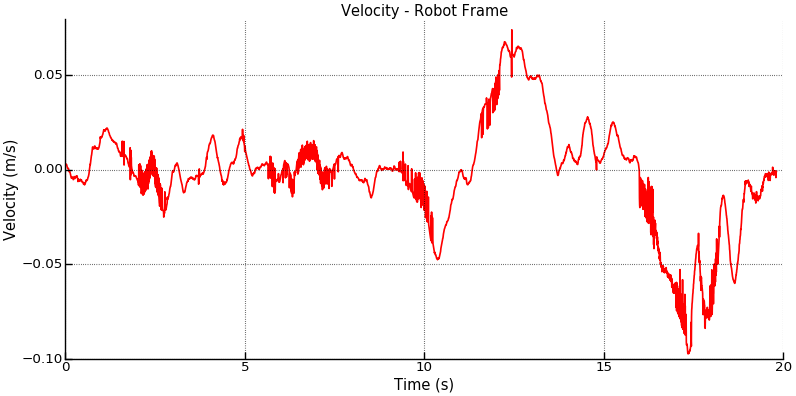

In [25]:
%matplotlib inline
cfg = pc['velocity'].copy()
cfg['runs'] = runs
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 20.0]
make_static_plot(df, cfg, 'VelocityVsTime')

## Tilt Plot

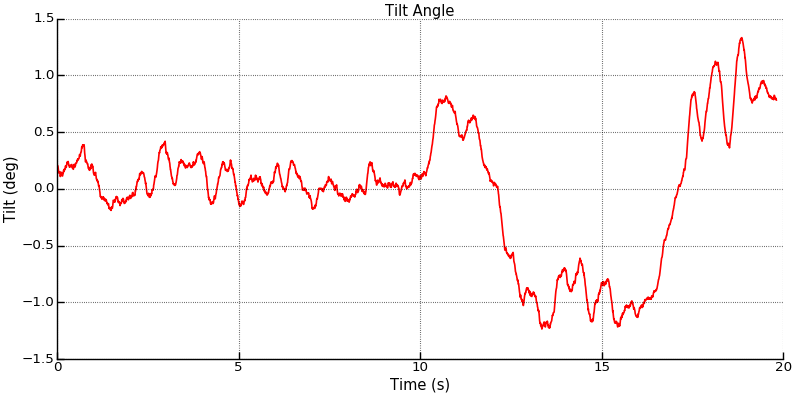

In [26]:
%matplotlib inline
cfg = pc['measured_tilt'].copy()
cfg['runs'] = runs
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 20.0]
make_static_plot(df, cfg, 'TiltVsTime')

## Turn Rate

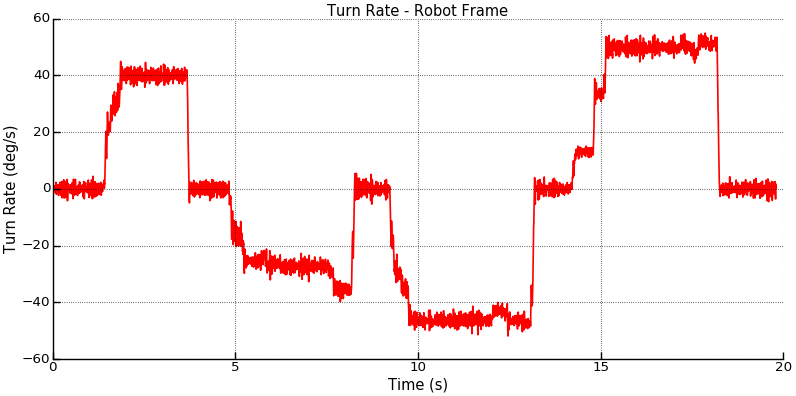

In [27]:
%matplotlib inline
cfg = pc['turn_rate'].copy()
cfg['runs'] = runs
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 20.0]
make_static_plot(df, cfg, 'TurnRateVsTime')

## Heading Plot Kp Runs

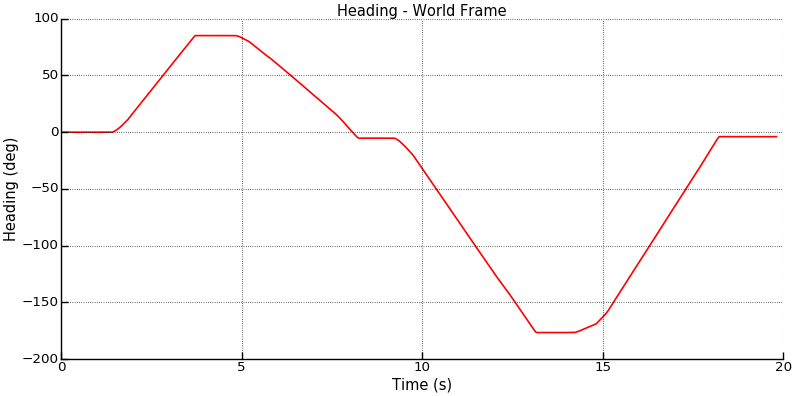

In [28]:
%matplotlib inline
cfg = pc['heading'].copy()
cfg['runs'] = runs
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 20.0]
make_static_plot(df, cfg, 'DerivedHeadingVsTime')

## Desired Turn Rate vs Actual

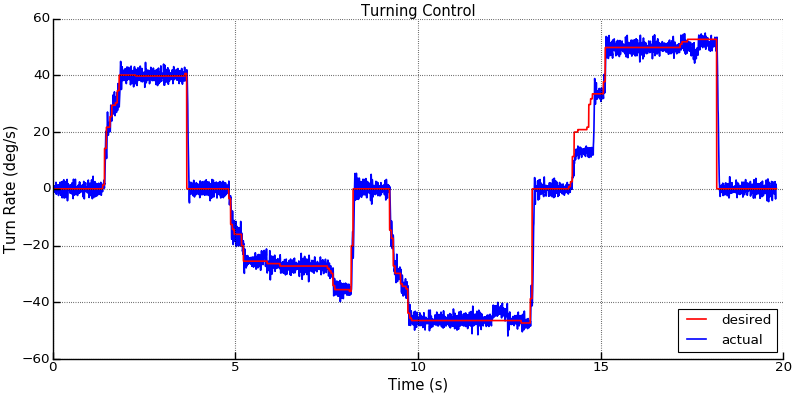

In [29]:
%matplotlib inline
cfg = pc['turning_control'].copy()
cfg['runs'] = runs
cfg['xlim'] = [0, 20]
make_static_plot(df, cfg, 'TurningControl', plot_func=desired_vs_actual_for_runs)

## Desired Heading vs Actual

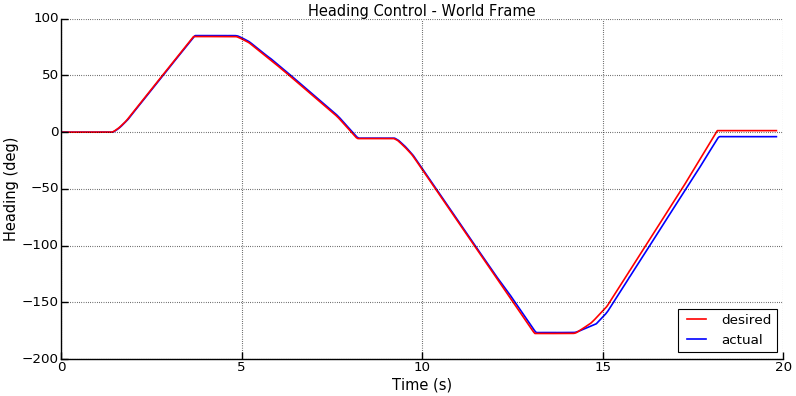

In [30]:
%matplotlib inline
cfg = pc['heading_control'].copy()
cfg['runs'] = runs
cfg['xlim'] = [0, 20]
make_static_plot(df, cfg, 'HeadingControl', plot_func=desired_vs_actual_for_runs)

## Position Plot Kp Runs

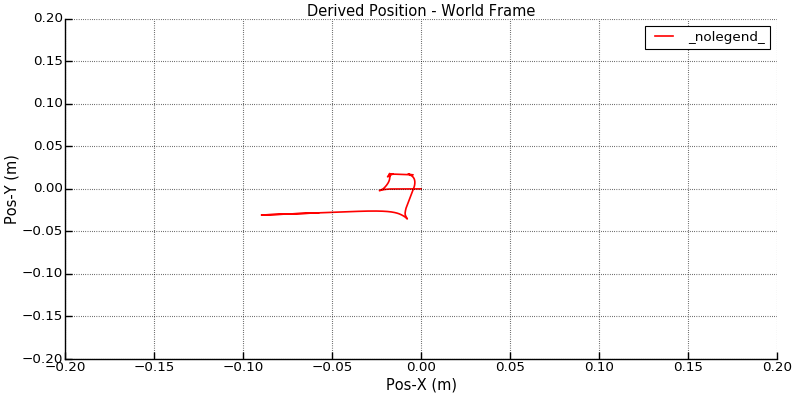

In [18]:
%matplotlib inline
cfg = pc['position_derived'].copy()
cfg['runs'] = runs
cfg['colors'] = ['red']
cfg['xlim'] = [-0.2, 0.2]
cfg['ylim'] = [-0.2, 0.2]
make_static_plot(df, cfg, 'DerivedPositionVsTime')

# Final Plots
This section contains just the finalized summary plots that capture the primary result of the analysis.

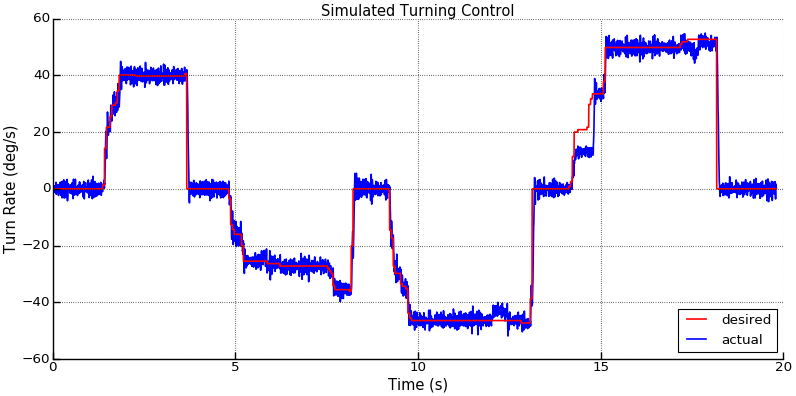

In [35]:
%matplotlib inline
cfg = pc['turning_control'].copy()
cfg['title'] = 'Simulated Turning Control'
cfg['runs'] = runs
cfg['xlim'] = [0, 20]
make_static_plot(df, cfg, 'TurningControl', plot_func=desired_vs_actual_for_runs)

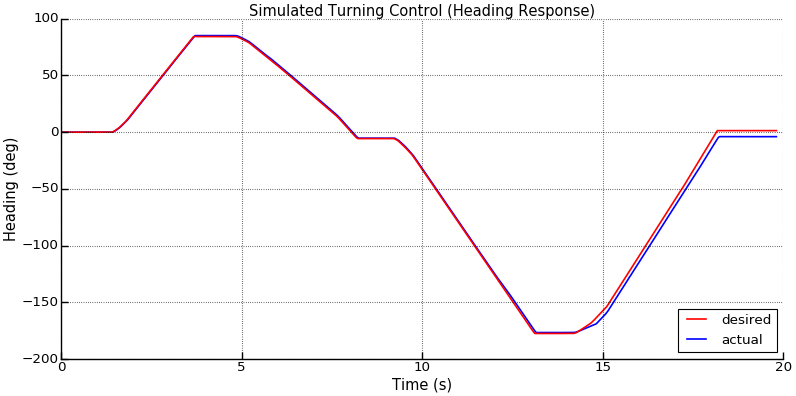

In [36]:
%matplotlib inline
cfg = pc['heading_control'].copy()
cfg['title'] = 'Simulated Turning Control (Heading Response)'
cfg['runs'] = runs
cfg['xlim'] = [0, 20]
make_static_plot(df, cfg, 'HeadingControl', plot_func=desired_vs_actual_for_runs)

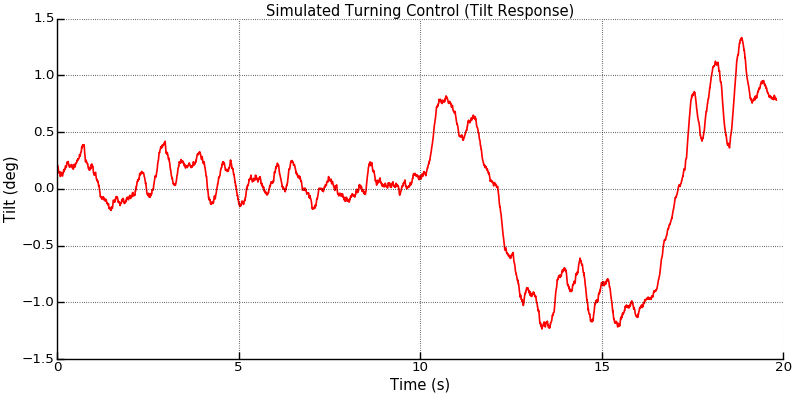

In [38]:
%matplotlib inline
cfg = pc['measured_tilt'].copy()
cfg['title'] = 'Simulated Turning Control (Tilt Response)'
cfg['runs'] = runs
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 20.0]
make_static_plot(df, cfg, 'TiltVsTime')

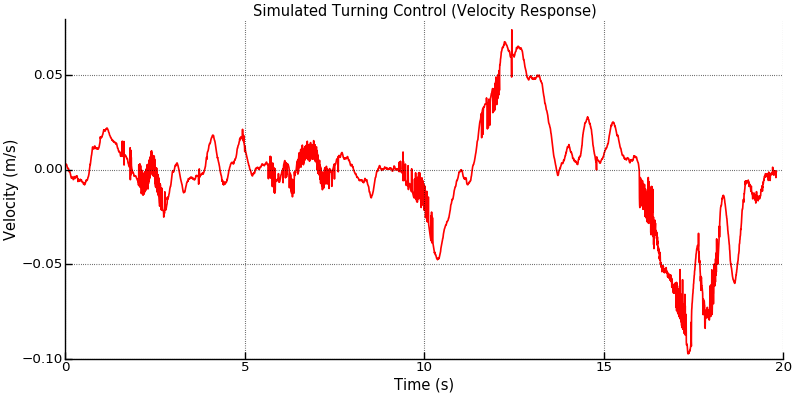

In [39]:
%matplotlib inline
cfg = pc['velocity'].copy()
cfg['title'] = 'Simulated Turning Control (Velocity Response)'
cfg['runs'] = runs
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 20.0]
make_static_plot(df, cfg, 'VelocityVsTime')

## HW Response

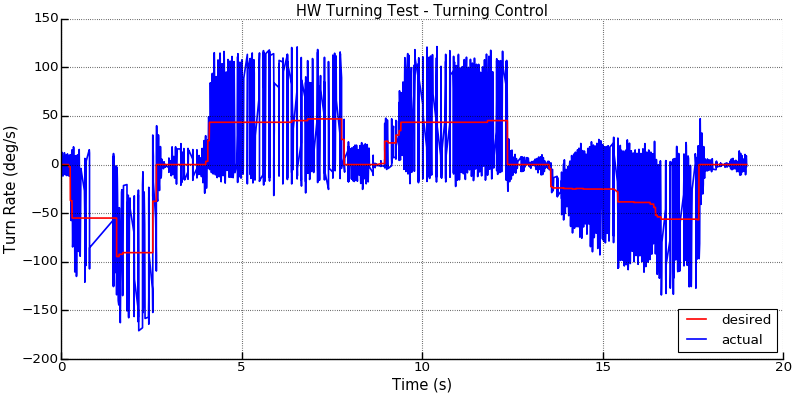

In [54]:
%matplotlib inline
cfg = pc['turning_control'].copy()
cfg['title'] = 'HW Turning Test - Turning Control'
cfg['runs'] = ['response_hw_test']
cfg['xlim'] = [0, 20]
make_static_plot(df, cfg, 'TurningControl', plot_func=desired_vs_actual_for_runs)

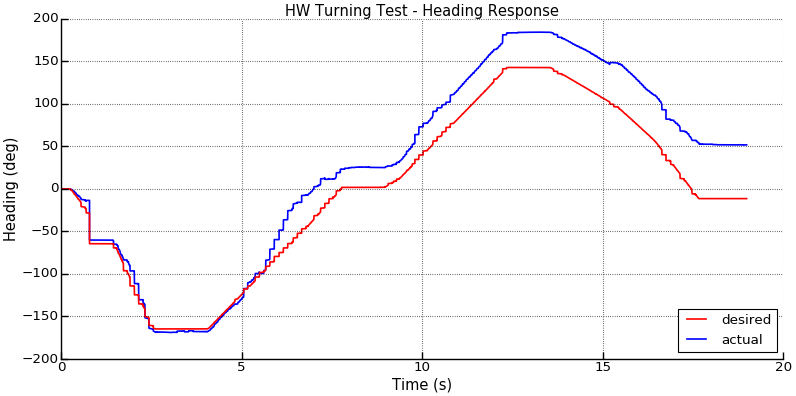

In [59]:
%matplotlib inline
cfg = pc['heading_control'].copy()
cfg['title'] = 'HW Turning Test - Heading Response'
cfg['runs'] = ['response_hw_test']
cfg['xlim'] = [0, 20]
make_static_plot(df, cfg, 'HeadingControl', plot_func=desired_vs_actual_for_runs)

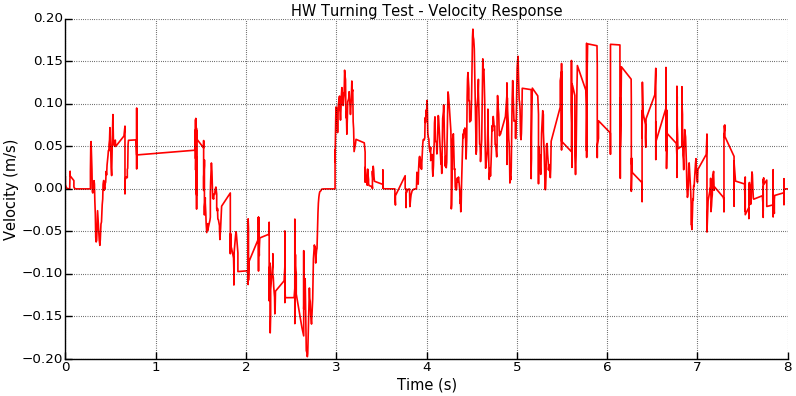

In [55]:
%matplotlib inline
cfg = pc['velocity'].copy()
cfg['title'] = 'HW Turning Test - Velocity Response'
cfg['runs'] = ['response_hw_test']
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 8.0]
make_static_plot(df, cfg, 'HwVelocityResponse')

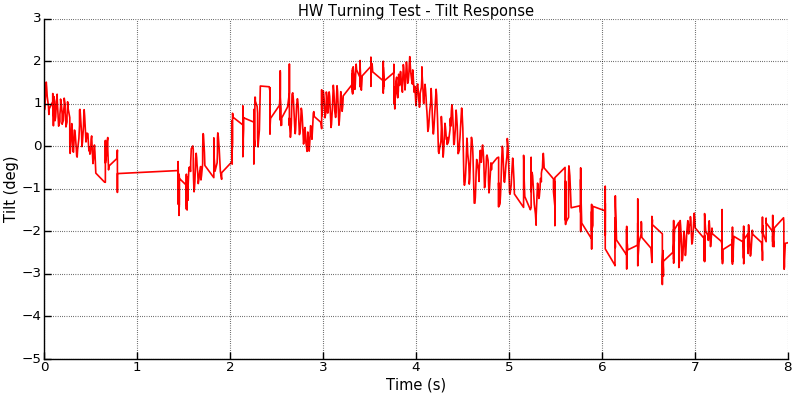

In [56]:
%matplotlib inline
cfg = pc['measured_tilt'].copy()
cfg['title'] = 'HW Turning Test - Tilt Response'
cfg['runs'] = ['response_hw_test']
cfg['colors'] = ['red']
cfg['xlim'] = [0.0, 8.0]
make_static_plot(df, cfg, 'HwTiltResponse')

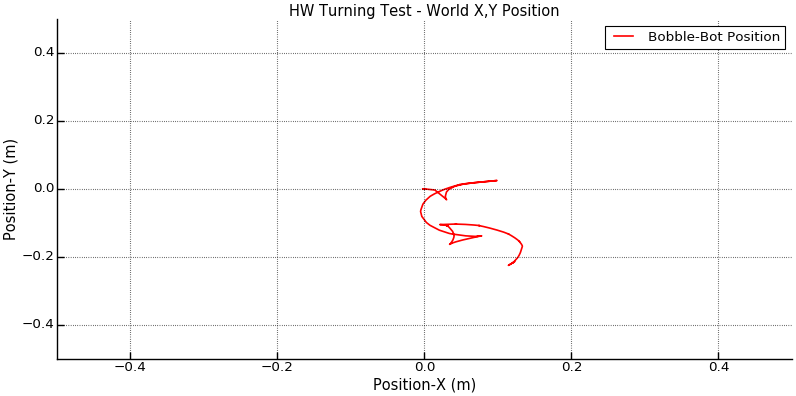

In [57]:
%matplotlib inline
cfg = pc['position_derived'].copy()
cfg['title'] = 'HW Turning Test - World X,Y Position'
cfg['runs'] = ['response_hw_test']
cfg['colors'] = ['red']
cfg['legend'] = {
    'Bobble-Bot Position': {
        'color': 'red',
        'linestyle': '-'
    },
}
cfg['legend_loc'] = 'upper right'
cfg['x_label'] = 'Position-X (m)'
cfg['y_label'] = 'Position-Y (m)'
cfg['xlim'] = [-0.5, 0.5]
cfg['ylim'] = [-0.5, 0.5]
make_static_plot(df, cfg, 'HwPositionResponse')